# Pricing Options with Machine Learning and Black Scholes

This notebook investigates option pricing using the **Black–Scholes model** and compares it with **machine learning regressors**. Synthetic data are generated from the analytical Black–Scholes formula, and models such as **Linear Regression**, **Random Forest**, and **Neural Networks (MLP)** are trained to learn the pricing function. The aim is to evaluate how well these ML models can approximate and generalise the theoretical Black–Scholes pricing surface.


# Import Libraries

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import numpy as np


import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent / "src"))
from black_scholes import BlackScholesData, PricingModel , black_scholes_call

# Model Training and Evaluation

We generate synthetic option data using the **Black–Scholes model** and split it into training and test sets. Four machine learning regressors are trained to learn the pricing relationship:

- **Linear Regression**
- **Random Forest Regressor**
- **Neural Network (ReLU activation)**
- **Neural Network (tanh activation)**

Each model is trained on the training set and evaluated on the test set using **Root Mean Squared Error (RMSE)** and the **coefficient of determination (R²)** to measure predictive accuracy.


In [4]:
data = BlackScholesData()
X_train, X_test, y_train, y_test = data.split()

models = [
    PricingModel("Linear", LinearRegression()),
    PricingModel("Random Forest", RandomForestRegressor(n_estimators=100, random_state=1)),
    PricingModel("ReLU NN", MLPRegressor(hidden_layer_sizes=(64,64), activation='relu', max_iter=1000)),
    PricingModel("tanh NN", MLPRegressor(hidden_layer_sizes=(64,64), activation='tanh', max_iter=1000))
]

results = {}
for m in models:
    m.train(X_train, y_train)
    rmse, r2, y_pred = m.evaluate(X_test, y_test)
    results[m.name] = (rmse, r2)
    print(f"{m.name:14s} | RMSE = {rmse:.4f} | R² = {r2:.4f}")


Linear         | RMSE = 9.0692 | R² = 0.8384
Random Forest  | RMSE = 1.4393 | R² = 0.9959
ReLU NN        | RMSE = 0.7813 | R² = 0.9988
tanh NN        | RMSE = 0.5806 | R² = 0.9993


# Model Performance Comparison

The models’ performance is compared using **RMSE** and **R²** metrics.  
A bar plot displays the RMSE values for each model, while an overlaid line plot shows the corresponding R² scores. Lower RMSE and higher R² indicate better predictive performance in reproducing Black–Scholes prices.

Additionally, the **training loss curves** for the neural network models are plotted across epochs to illustrate convergence behaviour and optimisation stability during training.


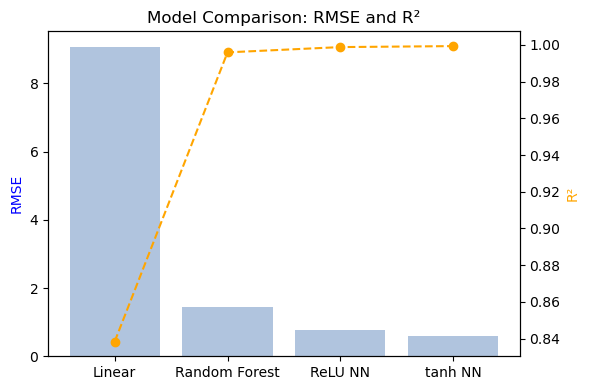

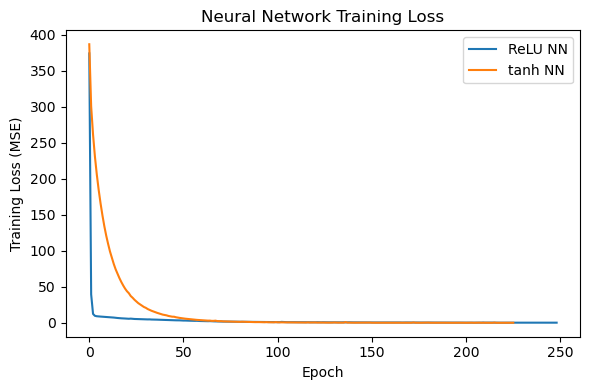

In [5]:
# --- Compare RMSE and R² ---
names = list(results.keys())
rmse = [results[n][0] for n in names]
r2 = [results[n][1] for n in names]

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.bar(names, rmse, color='lightsteelblue')
ax1.set_ylabel('RMSE', color='blue')
ax1.set_title('Model Comparison: RMSE and R²')

ax2 = ax1.twinx()
ax2.plot(names, r2, 'o--', color='orange', label='R²')
ax2.set_ylabel('R²', color='orange')
plt.tight_layout()
plt.show()

# --- Plot loss curves (for NN models only) ---
plt.figure(figsize=(6,4))
for m in models:
    if hasattr(m, "loss_curve_") and m.loss_curve_ is not None:
        plt.plot(m.loss_curve_, label=m.name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Neural Network Training Loss')
plt.legend()
plt.tight_layout()
plt.show()


# Predicted vs True Black–Scholes Prices

Each subplot compares the **predicted option prices** from a trained model against the **analytical Black–Scholes prices** on the test data.  
The dashed red line represents the ideal 1:1 relationship between predicted and true values.

Models with points closely aligned along this diagonal demonstrate stronger agreement with the theoretical pricing model, indicating higher accuracy and generalisation capability.


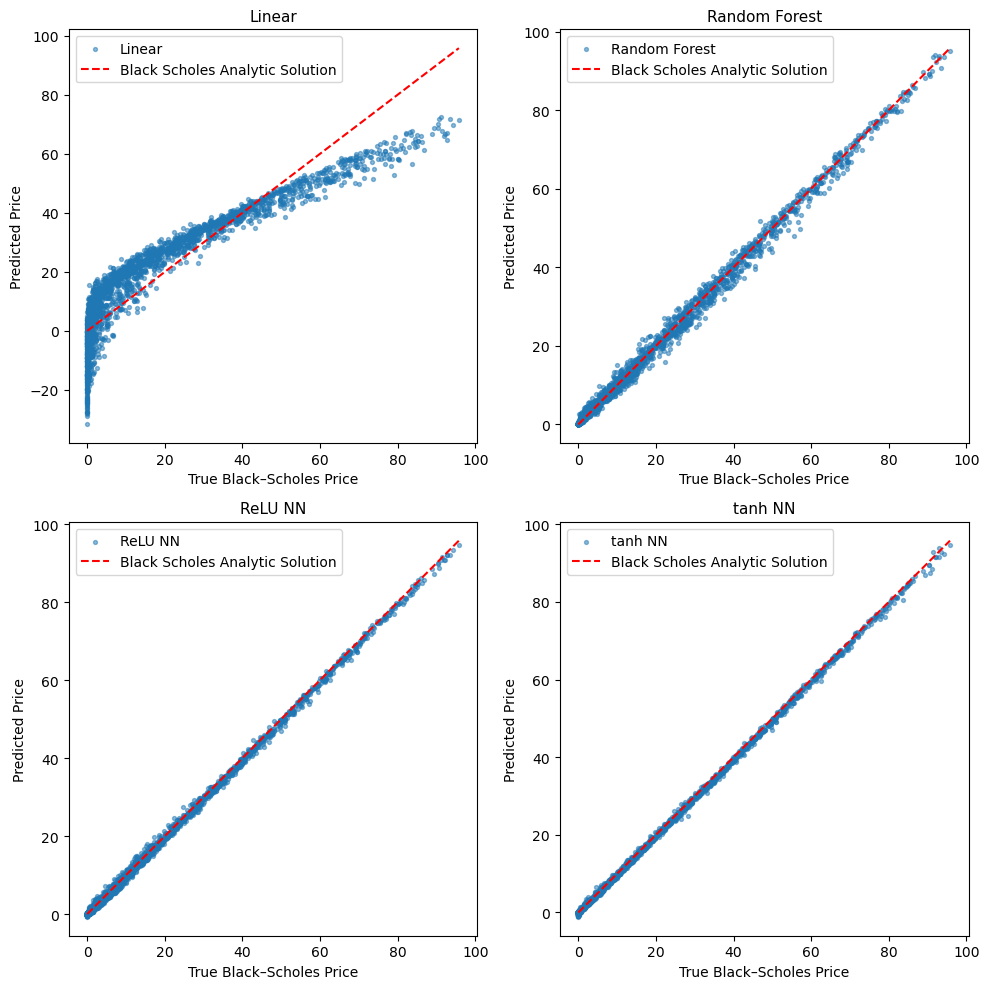

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, m in zip(axes, models):
    # Predict using the trained model
    y_pred = m.model.predict(X_test)
    
    # Scatter plot: true vs predicted
    ax.scatter(y_test, y_pred, s=8, alpha=0.5, label=m.name)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()], 'r--', lw=1.5, label = 'Black Scholes Analytic Solution')
    
    # Labels and formatting
    ax.set_title(f'{m.name}', fontsize=11)
    ax.set_xlabel('True Black–Scholes Price')
    ax.set_ylabel('Predicted Price')
    ax.legend(loc='upper left')
    ax.grid(False)

plt.tight_layout()
plt.show()


# Learned vs Analytical Pricing Surfaces

The best-performing model, determined by the highest **R² score**, is used to reconstruct the option pricing surface.  
Both the **true analytical Black–Scholes surface** and the **model-learned surface** are plotted over varying spot and strike prices (S and K) with fixed time to maturity, interest rate, and volatility.

Visual comparison between the two surfaces highlights how accurately the selected machine learning model captures the nonlinear dependencies in the Black–Scholes pricing function.


In [ ]:
# Pick the best-performing model
best_name = max(results, key=lambda k: results[k][1])
best_model = next(m for m in models if m.name == best_name)

# Generate grid for S and K
S_grid = np.linspace(50, 150, 40)
K_grid = np.linspace(50, 150, 40)
Sg, Kg = np.meshgrid(S_grid, K_grid)

# Fix T, r, sigma
T_val, r_val, sigma_val = 1.0, 0.02, 0.2

# Flatten grid for prediction
X_grid = np.column_stack([
    Sg.ravel(),
    Kg.ravel(),
    np.full_like(Sg.ravel(), T_val),
    np.full_like(Sg.ravel(), r_val),
    np.full_like(Sg.ravel(), sigma_val)
])

# Compute analytical Black–Scholes surface
true_surface = black_scholes_call(Sg, Kg, T_val, r_val, sigma_val)

# Predict surface using best model
pred_surface = best_model.model.predict(X_grid).reshape(Sg.shape)



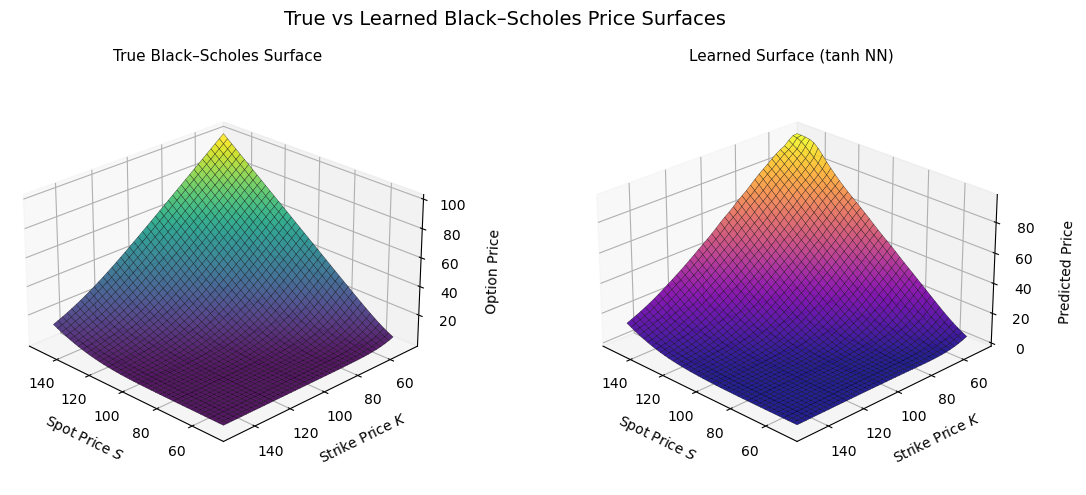

In [8]:
fig = plt.figure(figsize=(12,5))

# --- True Black–Scholes Surface ---
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.plot_surface(Sg, Kg, true_surface,
                 cmap='viridis', edgecolor='k', linewidth=0.2, alpha=0.9)
ax1.set_title('True Black–Scholes Surface', fontsize=11)
ax1.set_xlabel('Spot Price $S$', labelpad=8)
ax1.set_ylabel('Strike Price $K$', labelpad=8)
ax1.set_zlabel('Option Price', labelpad=8)
ax1.view_init(elev=25, azim=135)
ax1.set_box_aspect([1,1,0.6])  # balanced proportions

# --- Learned Surface ---
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.plot_surface(Sg, Kg, pred_surface,
                 cmap='plasma', edgecolor='k', linewidth=0.2, alpha=0.9)
ax2.set_title(f'Learned Surface ({best_name})', fontsize=11)
ax2.set_xlabel('Spot Price $S$', labelpad=8)
ax2.set_ylabel('Strike Price $K$', labelpad=8)
ax2.set_zlabel('Predicted Price', labelpad=8)
ax2.view_init(elev=25, azim=135)
ax2.set_box_aspect([1,1,0.6])

plt.suptitle('True vs Learned Black–Scholes Price Surfaces', fontsize=14)
plt.tight_layout()
plt.show()


# Feature Importance Analysis

To interpret the models, we examine the **feature importance** for both tree-based and neural network regressors.

- For the **Random Forest**, feature importance is derived from the model’s internal splitting criteria, revealing which inputs most influence option price predictions.
- For the **Neural Network (tanh)**, **permutation importance** is used to measure the change in R² when each feature is randomly shuffled, indicating its contribution to predictive accuracy.

This comparison highlights which market parameters — such as spot price, strike price, time to maturity, interest rate, or volatility — are most critical for accurate option valuation.


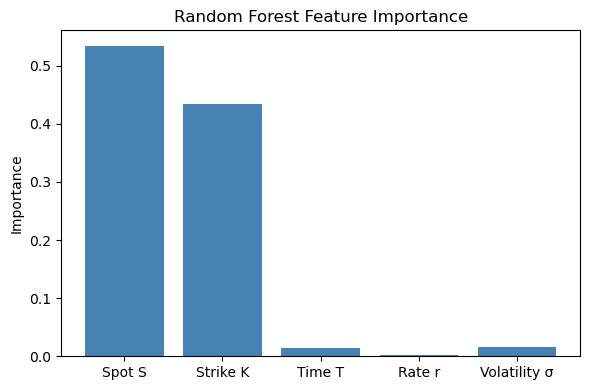

In [15]:
# Assume your Random Forest model is already trained as `rf_model`
rf_model = next(m for m in models if m.name == "Random Forest")

importances = rf_model.model.feature_importances_
features = ['Spot S', 'Strike K', 'Time T', 'Rate r', 'Volatility σ']

plt.figure(figsize=(6,4))
plt.bar(features, importances, color='steelblue')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


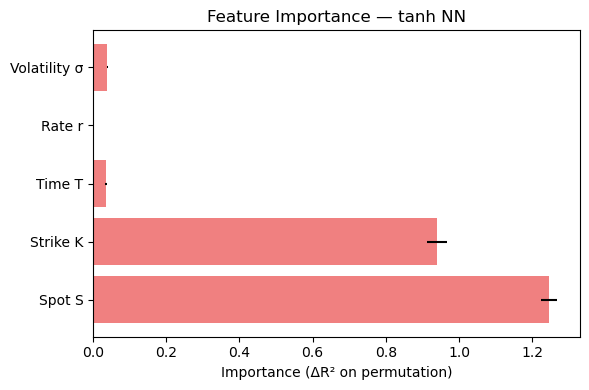

In [16]:
from sklearn.inspection import permutation_importance

best_model = next(m for m in models if "tanh" in m.name)
result = permutation_importance(best_model.model, X_test, y_test,
                                n_repeats=5, random_state=1, scoring='r2')

importances = result.importances_mean
std = result.importances_std
features = ['Spot S', 'Strike K', 'Time T', 'Rate r', 'Volatility σ']

plt.figure(figsize=(6,4))
plt.barh(features, importances, xerr=std, color='lightcoral')
plt.xlabel('Importance (ΔR² on permutation)')
plt.title(f'Feature Importance — {best_model.name}')
plt.tight_layout()
plt.show()


# Regime-Specific Feature Importance

To explore how feature relevance changes under different market conditions, the dataset is divided into **volatility** and **maturity** regimes:

- **Low vs High Volatility**: σ < 0.25 and σ ≥ 0.25  
- **Short vs Long Maturity**: T < 0.5 and T ≥ 0.5  

A separate **Random Forest Regressor** is trained within each regime, and feature importance is computed to identify which variables dominate option pricing under those conditions.

This analysis reveals how the influence of spot price, strike, maturity, rate, and volatility evolves across different market environments.


In [ ]:
# Split data by volatility or time regime
low_vol = data.X[:,4] < 0.25
high_vol = data.X[:,4] >= 0.25

short_T = data.X[:,2] < 0.5
long_T = data.X[:,2] >= 0.5

def get_feature_importance(X, y, title):
    model = RandomForestRegressor(n_estimators=200, random_state=1)
    model.fit(X, y)
    importances = model.feature_importances_
    features = ['Spot S', 'Strike K', 'Time T', 'Rate r', 'Volatility σ']

    plt.figure(figsize=(5,3))
    plt.bar(features, importances, color='steelblue')
    plt.title(title)
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()
    return importances


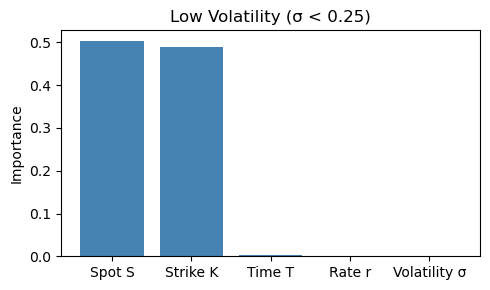

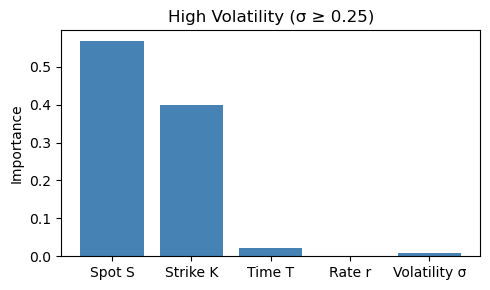

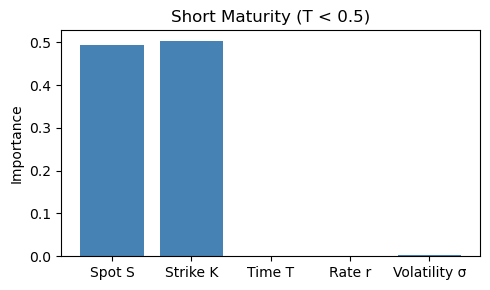

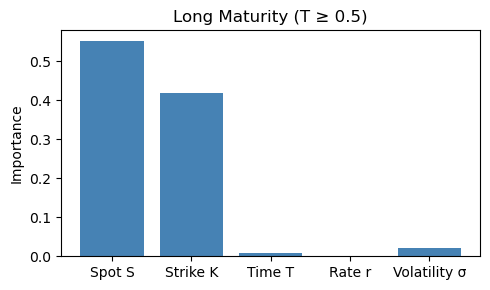

In [20]:
# Volatility regimes
imp_low_vol  = get_feature_importance(data.X[low_vol],  data.y[low_vol],  'Low Volatility (σ < 0.25)')
imp_high_vol = get_feature_importance(data.X[high_vol], data.y[high_vol], 'High Volatility (σ ≥ 0.25)')

# Maturity regimes
imp_short_T  = get_feature_importance(data.X[short_T],  data.y[short_T],  'Short Maturity (T < 0.5)')
imp_long_T   = get_feature_importance(data.X[long_T],   data.y[long_T],   'Long Maturity (T ≥ 0.5)')
